<a href="https://colab.research.google.com/github/Sammy-Reeves/Issue-2-electric-bagaloo/blob/main/Short_Scripts/Week_4_Download_Climate_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and visualise ERA5 climate data

## Import GEE and relevant tools

In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

ee.Authenticate()  # Trigger the authentication flow.
ee.Initialize(project='ee-sammyreeveswork')    # Change to your own default project name.

## Download ERA5 time series at a point

Set variables here. Additional variables can be downloaded by adding to the `variables` list by consulting the [Earth Engine documentation](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR#bands).

In [2]:
# Location - editable
latitude = 40.53927   # Degrees of latitude
longitude = -122.56656  # Degrees of longitude
location_name = 'ShastaCalifornia'  # recognisable name, to create a useful file name

# Google Drive export folder
folder = 'scires_project_2A'

# Names of the variables we want to download -- add more if you like!
variables = [
    'temperature_2m',
    'total_precipitation_sum',
    ]

## Download ERA5 data

In [7]:
# Create a point geometry at the specified location
point = ee.Geometry.Point(longitude, latitude)

# Define the dataset as the ERA5 monthly mean data
dataset = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')

# Filter the dataset to the desired time range
dataset = dataset.filter(ee.Filter.date('2015-01-01', '2021-01-01'))

# Select only the relevant variables
dataset = dataset.select(variables)

# Go through the collection, finding the nearest values to the set lat/lon
dataset = dataset.map(
    lambda image: image.set(
        'era5',
        image.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=image.projection().nominalScale()  # Use native resolution
        ).set('year', image.date().get('year')).set('month', image.date().get('month'))
    )
)

# Get this data as a dictionary, and turn it into a Pandas dataframe (table)
era5_dict = dataset.aggregate_array('era5').getInfo()
era5 = pd.DataFrame(era5_dict)

# Construct a proper 'date' column from the year and month data.
dates = pd.to_datetime(dict(year=era5.year, month=era5.month, day=15))

# Drop the 'year' and 'month' columns and insert the 'date' column instead as the first column.
era5.drop(labels=['year', 'month'], axis=1,inplace = True)
era5.insert(0, 'date', dates)

# Visualise table
era5

,date,temperature_2m,total_precipitation_sum
0,2015-01-15,281.604981,0.020109
1,2015-02-15,283.630824,0.157900
2,2015-03-15,285.797458,0.028803
3,2015-04-15,286.351173,0.042181
4,2015-05-15,291.206364,0.016673
...,...,...,...
67,2020-08-15,301.103753,0.002183
68,2020-09-15,297.881372,0.000152
69,2020-10-15,292.973469,0.000282
70,2020-11-15,282.457253,0.055771


The below cell 'corrects' the data, converting temperature from K to ˚C and precipitaiton from m to mm. If you add additional variables, you may wish to add to this cell with your own 'corrections'.

In [8]:
# Create new 'corrected' table as a copy of the first.
era5_corr = era5.copy()

# Transition temperature from Kelvin to Celcius
era5_corr['temperature_2m'] = era5_corr['temperature_2m'] - 274.15

# Transition total rainfall from m to mm
era5_corr['total_precipitation_sum'] = era5_corr['total_precipitation_sum'] * 1000

# Visualise new table
era5_corr

,date,temperature_2m,total_precipitation_sum
0,2015-01-15,7.454981,20.109288
1,2015-02-15,9.480824,157.900167
2,2015-03-15,11.647458,28.803030
3,2015-04-15,12.201173,42.180917
4,2015-05-15,17.056364,16.673010
...,...,...,...
67,2020-08-15,26.953753,2.182800
68,2020-09-15,23.731372,0.151791
69,2020-10-15,18.823469,0.282486
70,2020-11-15,8.307253,55.770999


Visualise temperature and precipitation data for quality assessment.

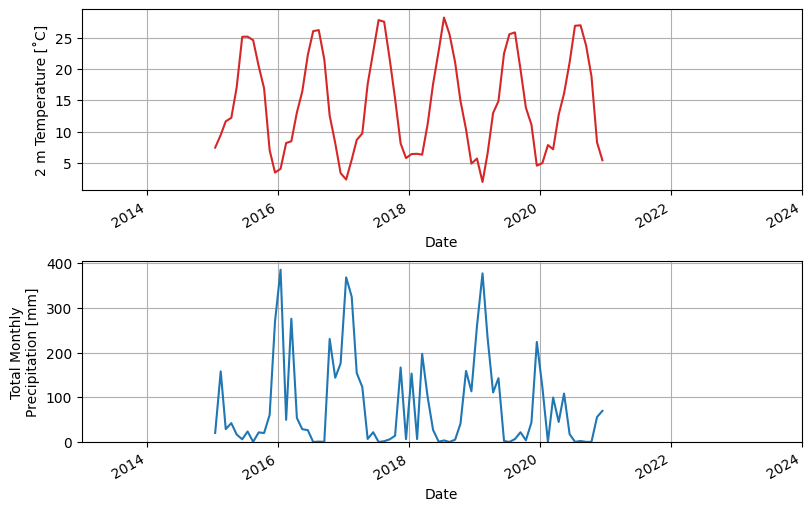

In [9]:
fig, axes = plt.subplots(nrows=2, layout='constrained', figsize=(8, 5))

# For the first axis...
ax = axes[0]
# Plot the temperature in red on the first axis
era5_corr.plot('date', 'temperature_2m', ax=ax, color='tab:red', legend=False)
# Set the y axis label
ax.set_ylabel('2 m Temperature [˚C]')

# For the second axis...
ax = axes[1]
# Plot the total monthly precipitaiton in blue on the second axis
era5_corr.plot('date', 'total_precipitation_sum', ax=ax, color='tab:blue', legend=False)
# Set the y axis label ('\n' forces a line break to fit it on the axis)
ax.set_ylabel('Total Monthly\nPrecipitation [mm]')
# Set the y lower limit to zero
ax.set_ylim(0, None)

for ax in axes:  # Loop through both axes, applying the same rules to both

  # Apply a grid
  ax.grid()

  # Set the x axis limits between 2013 and 2024
  ax.set_xlim(pd.to_datetime('2013-01-01'), pd.to_datetime('2024-01-01'))

  # Set the x axis label to 'Date'
  ax.set_xlabel('Date')


## Export data to Google Drive

In [11]:
# Mount google drive
drive.mount('/content/drive')

# Construct the filename automatically
filename = location_name + '_era5.csv'

# Print out filename for reference
print("The image will be saved to your Google Drive at:\n" + folder + '/' + filename + '\n')

# Export the pandas dataframe to a csv file
era5_corr.to_csv(f'/content/drive/My Drive/{folder}/{filename}', index=False)

print('Saved.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The image will be saved to your Google Drive at:
scires_project_2A/ShastaCalifornia_era5.csv

Saved.
